In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

2025-04-15 12:42:36.739780: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 12:42:36.849173: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 12:42:36.952655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744695757.039807    5883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744695757.064290    5883 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744695757.236551    5883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
IMG_SIZE = 224  # size image
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 2  # Jati dan Mahoni

In [3]:
# fungsi untuk load gambar jati dan mahoni dan pelabelan pada gambar (jati dan mahoni)
def load_images(jati_dir, mahoni_dir):
    images = []
    labels = []
    
    # menaruh path gambar jati pada var images dan memberi label 0 pada gambar jati
    for filename in os.listdir(jati_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(jati_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image was loaded successfully
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(0)
    
    # menaruh path gambar mahoni pada var images dan memberi label 1 pada gambar mahoni
    for filename in os.listdir(mahoni_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(mahoni_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image was loaded successfully
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(1)
    
    return np.array(images), np.array(labels)

In [4]:
# GLCM feature extraction
def extract_glcm_features(image):
    # konversi gambar ke grayscale jika gambar berwarna
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # mengurangi jumlah level intensitas dari 256 (0–255) menjadi hanya 8 level (karena 255/32 ≈ 8)
    gray = (gray / 32).astype(np.uint8)
    
    # menghitung fitur GLCM pada berbagai sudut
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 derajat
    
    # menghitung matriks GLCM
    glcm = graycomatrix(gray, distances, angles, levels=8, symmetric=True, normed=True)
    
    # menghitung properti GLCM
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    ASM = graycoprops(glcm, 'ASM').mean()
    
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation, ASM])


In [5]:
# ekstraks fitur GLCM untuk semua gambar
def extract_features_from_dataset(images):
    glcm_features = []
    for img in images:
        glcm_features.append(extract_glcm_features(img))
    return np.array(glcm_features)

In [6]:
# build model CNN dengan fitur GLCM
def build_model():
    # CNN input
    cnn_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    cnn_output = Dense(64, activation='relu')(x)
    
    # GLCM feature input
    glcm_input = Input(shape=(6,))  # 6 GLCM features
    glcm_output = Dense(16, activation='relu')(glcm_input)
    
    # menggabungkan fitur CNN dan GLCM
    combined = concatenate([cnn_output, glcm_output])
    
    # Output layer
    output = Dense(NUM_CLASSES, activation='softmax')(combined)
    
    # Create model
    model = Model(inputs=[cnn_input, glcm_input], outputs=output)
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
jati_dir = './dataset/jati'  # path gambar jati
mahoni_dir = './dataset/mahoni'  # path gambar mahoni

# load images dan labels
print("load path gambar dan load label gambar.....")
images, labels = load_images(jati_dir, mahoni_dir)

# ekstrak fitur GLCM
print("ekstraksi fitur GLCM...")
glcm_features = extract_features_from_dataset(images)

# normalissasi image data
images = images / 255.0

# konversi label ke categorical
labels_categorical = to_categorical(labels, NUM_CLASSES)

# Split the data
X_train_img, X_test_img, X_train_glcm, X_test_glcm, y_train, y_test = train_test_split(
    images, glcm_features, labels_categorical, test_size=0.2, random_state=42)

# augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# membangun model
print("membangun model...")
model = build_model()
model.summary()

load path gambar dan load label gambar.....
ekstraksi fitur GLCM...
membangun model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │    147,584 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 18432)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  9,437,696 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     32,832 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        112 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │        162 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,711,634 (37.05 MB)

 Trainable params: 9,711,634 (37.05 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train the model
print("training model...")
history = model.fit(
    [X_train_img, X_train_glcm],
    y_train,
    validation_data=([X_test_img, X_test_glcm], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

training model...
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5344 - loss: 0.7770 - val_accuracy: 0.5000 - val_loss: 0.7201
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5100 - loss: 0.6939 - val_accuracy: 0.8182 - val_loss: 0.6025
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8693 - loss: 0.5056 - val_accuracy: 0.8864 - val_loss: 0.2864
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8559 - loss: 0.3346 - val_accuracy: 0.8864 - val_loss: 0.3028
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9106 - loss: 0.2339 - val_accuracy: 0.9091 - val_loss: 0.2400
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9231 - loss: 0.2061 - val_accuracy: 0.9091 - val_loss: 0.2835
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9619 - loss: 0.1264 - val_accuracy: 0.8864 - val_loss: 0.3061
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9171 - loss: 0.2499 - val_accuracy: 0.9091 - val_los

In [10]:
# evaluasi model
print("evaluasi model...")
loss, accuracy = model.evaluate([X_test_img, X_test_glcm], y_test)
print(f"akurasi test: {accuracy:.4f}")

evaluasi model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.9337 - loss: 0.2383
akurasi test: 0.9318


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step
                   precision    recall  f1-score   support

      Jati (Teak)       0.88      1.00      0.94        22
Mahoni (Mahogany)       1.00      0.86      0.93        22

         accuracy                           0.93        44
        macro avg       0.94      0.93      0.93        44
     weighted avg       0.94      0.93      0.93        44



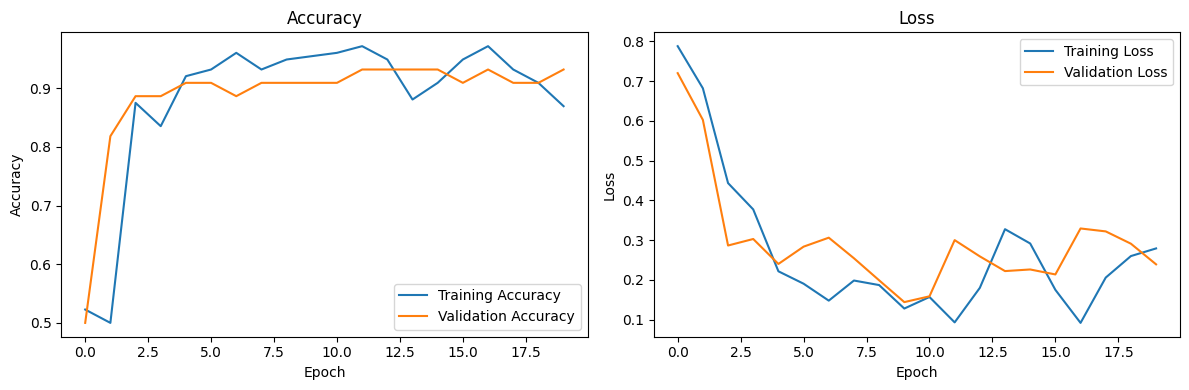

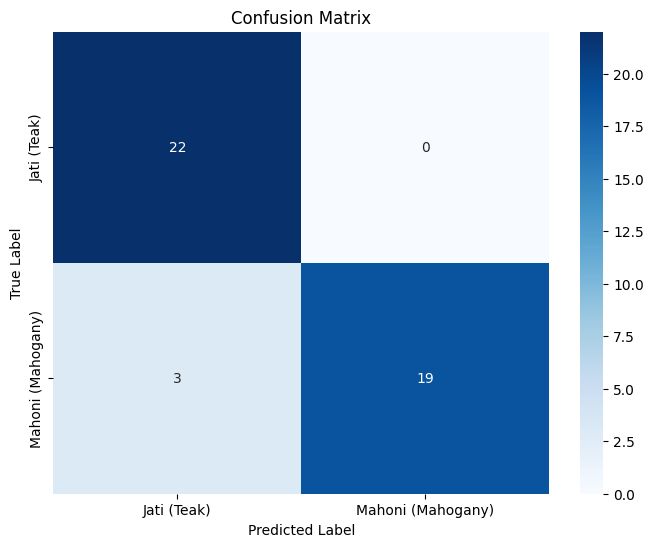

In [11]:
# memprediksi
y_pred = model.predict([X_test_img, X_test_glcm])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_names = ['Jati (Teak)', 'Mahoni (Mahogany)']
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# visualisasi hasil
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()


# plot hasil
plot_history(history)
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

In [18]:
# save model
model.save('wood_texture_classifier_model.keras')
print("model tersimpan")

model tersimpan
